In [18]:
import os
import math
import random
from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.ops as ops

config = [
    (32, 3,1),
    (64, 3, 2),
    ["B" , 1],
    (128, 3 ,2),
    ["B", 2],
    (256, 3, 2),
    ["B" , 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if bn_act else nn.Identity()
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn_act:
            x = self.bn(x)
            x = self.leaky(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_repeats):
            self.layers.append(
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            )
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes

    def forward(self, x):
        B, C, H, W = x.shape
        return (
            self.pred(x)
            .reshape(B, 3, self.num_classes + 5, H, W)
            .permute(0, 1, 3, 4, 2)
        )

class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            # store route from last residual block with 8 repeats
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

    def _create_conv_layers(self):
            layers = nn.ModuleList()
            in_channels = self.in_channels
    
            for module in config:
                if isinstance(module, tuple):
                    out_channels, kernel_size, stride = module
                    layers.append(
                        CNNBlock(
                            in_channels,
                            out_channels,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=1 if kernel_size == 3 else 0,
                        )
                    )
                    in_channels = out_channels
    
                elif isinstance(module, list):
                    num_repeats = module[1]
                    layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
                
                elif isinstance(module, str):
                    if module == "S":
                        layers += [
                            ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                            CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                            ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                        ]
                        in_channels = in_channels // 2
        
                    elif module == "U":
                        layers.append(nn.Upsample(scale_factor=2),)
                        in_channels = in_channels * 3
        
            return layers




**DataSet**

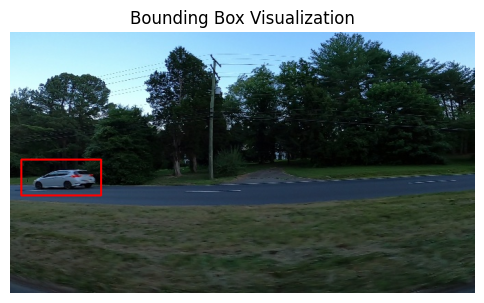

In [9]:
import cv2
import matplotlib.pyplot as plt


image_path = "/kaggle/input/car-object-detection/data/training_images/vid_4_10060.jpg"
xmin, ymin, xmax, ymax = 16.63096961, 186.5460103, 132.5586107, 238.3864221# bounding box coordinates

# Read the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB for proper display

# Draw the bounding box (red rectangle)
cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=(255, 0, 0), thickness=2)

# Display
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Bounding Box Visualization")
plt.show()


In [19]:
class CarDataset(Dataset):
    def __init__(self, images_dir, annotations_csv, img_size=416, transforms=None):

        #annotations_csv  columns: image, xmin, ymin, xmax, ymax
        
        self.images_dir = Path(images_dir)
        self.df = pd.read_csv(annotations_csv)
        # Keep only bounding boxes with non-zero area
        self.df = self.df[self.df['xmax'] > self.df['xmin']]
        # Group by image
        grouped = defaultdict(list)
        for _, row in self.df.iterrows():
            img = row['image']
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            grouped[img].append([xmin, ymin, xmax, ymax, 0])  # class 0 = car
        self.image_list = list(grouped.keys())
        self.boxes = grouped
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = self.images_dir / img_name
        img = cv2.imread(str(img_path))
        if img is None:
            # try with jpg or png fix
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H0, W0 = img.shape[:2]
        # resize, keep it simple (YOLO commonly uses 416)
        img = cv2.resize(img, (self.img_size, self.img_size))
        # normalize to [0,1]
        img = img.astype(np.float32) / 255.0
        # HWC -> CHW
        img_tensor = torch.tensor(img).permute(2, 0, 1)

        # convert boxes to normalized cx,cy,w,h relative to resized image
        boxes = np.array(self.boxes[img_name], dtype=np.float32)  # Nx5 (xmin,ymin,xmax,ymax,class)
        # convert according to original -> resized (but we resized ignoring aspect ratio)
        scale_x = self.img_size / W0
        scale_y = self.img_size / H0
        boxes[:, [0,2]] *= scale_x
        boxes[:, [1,3]] *= scale_y
        # convert to normalized cx,cy,w,h (0..1)
        x_centers = (boxes[:,0] + boxes[:,2]) / 2.0 / self.img_size
        y_centers = (boxes[:,1] + boxes[:,3]) / 2.0 / self.img_size
        widths = (boxes[:,2] - boxes[:,0]) / self.img_size
        heights = (boxes[:,3] - boxes[:,1]) / self.img_size
        classes = boxes[:,4].astype(np.int64)
        target = np.stack([classes, x_centers, y_centers, widths, heights], axis=1)  # (N,5)

       
        return img_tensor, torch.tensor(target, dtype=torch.float32), img_name


In [20]:
# Non Max Suppression wrapper
def nms_boxes(boxes_xywh, scores, iou_thresh=0.5, score_thresh=0.3):
    # boxes_xywh in normalized cx,cy,w,h -> convert to x1,y1,x2,y2 in absolute (0..1)
    cx = boxes_xywh[:,0]
    cy = boxes_xywh[:,1]
    w = boxes_xywh[:,2]
    h = boxes_xywh[:,3]
    x1 = (cx - w/2)
    y1 = (cy - h/2)
    x2 = (cx + w/2)
    y2 = (cy + h/2)
    boxes_xyxy = torch.stack([x1,y1,x2,y2], dim=1)
    keep = ops.nms(boxes_xyxy, scores, iou_thresh)
    return keep, boxes_xyxy

In [58]:
def cellboxes_to_boxes(output, anchors, S):
    device = output.device
    B, A, H, W, C = output.shape
    outputs = output.clone()

    grid_y, grid_x = torch.meshgrid(torch.arange(S), torch.arange(S), indexing="ij")
    grid_x, grid_y = grid_x.to(device), grid_y.to(device)

    cx = (outputs[..., 0] + grid_x[None,None,...]) / W
    cy = (outputs[..., 1] + grid_y[None,None,...]) / H

    # anchors expected shape: (3, 2)
    pw = (torch.exp(outputs[..., 2]) * anchors[:, 0].view(1, A, 1, 1)) / S
    ph = (torch.exp(outputs[..., 3]) * anchors[:, 1].view(1, A, 1, 1)) / S

    # Convert cx,cy,pw,ph → x1,y1,x2,y2
    x1 = cx - pw / 2
    y1 = cy - ph / 2
    x2 = cx + pw / 2
    y2 = cy + ph / 2

    boxes = torch.stack([x1, y1, x2, y2], dim=-1)
    obj = outputs[..., 4]
    cls_probs = outputs[..., 5:]

    return boxes, obj, cls_probs


   

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 416
BATCH_SIZE = 8
NUM_WORKERS = 4
NUM_CLASSES = 1  # car only
LEARNING_RATE = 1e-4
EPOCHS = 20
SAVE_DIR = Path( "/kaggle/working/yolov3_epoch1.pth")
SAVE_DIR.mkdir(exist_ok=True)

# Default YOLOv3 anchors (width,height) on the original scale (pixels) (commonly used)
ANCHORS = [
    [(116,90), (156,198), (373,326)],  # large scale (S=32)
    [(30,61), (62,45), (59,119)],      # medium scale (S=16)
    [(10,13), (16,30), (33,23)],       # small scale (S=8)
]
SCALES = [32, 16, 8] 

**Loss**

In [23]:
class SimpleYOLOLoss(nn.Module):
    def __init__(self, anchors, S, lambda_box=5, lambda_noobj=0.5):
        super().__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')  # operate on raw logits
        self.anchors = anchors
        self.S = S
        self.lambda_box = lambda_box
        self.lambda_noobj = lambda_noobj

    def forward(self, outputs, targets):
        
        device = outputs[0].device
        batch_size = outputs[0].shape[0]
        total_loss = torch.tensor(0., device=device)
        loss_box = 0.
        loss_obj = 0.
        loss_noobj = 0.
        loss_cls = 0.

      # for every scale, treat each cell and anchor as prediction.
        # We'll create target tensors per output that are zeros and fill cells that correspond to GTs.
        for scale_i, out in enumerate(outputs):
            B, A, H, W, C = out.shape
            out = out.view(B, A, H, W, C)
            stride = SCALES[scale_i]
            anchor_set = torch.tensor(ANCHORS[scale_i], dtype=torch.float32).to(device)
            # build target tensors
            t_cls = torch.zeros_like(out[..., 5:])
            t_obj = torch.zeros_like(out[..., 4])
            t_box = torch.zeros_like(out[..., :4])
            # For each image in batch, assign GTs naively:
            for b in range(B):
                gt = targets[b]  # Nx5: (class, cx, cy, w, h) normalized
                if gt.numel() == 0:
                    continue
                for g in gt:
                    cls_id = int(g[0].item())
                    cx, cy, w_norm, h_norm = g[1].item(), g[2].item(), g[3].item(), g[4].item()
                    # find which cell this gt falls into at this scale
                    cell_x = int(cx * W)
                    cell_y = int(cy * H)
                    if cell_x < 0 or cell_x >= W or cell_y < 0 or cell_y >= H:
                        continue
                    # choose best anchor by IoU with gt (anchor w/h scaled by 1/S)
                    # convert anchor dims to normalized by dividing by IMG_SIZE
                    anchors_norm = anchor_set / IMG_SIZE
                    gt_box = torch.tensor([0.,0.,w_norm,h_norm], device=device).unsqueeze(0)
                    anchors_box = torch.cat([torch.zeros_like(anchors_norm).unsqueeze(1), anchors_norm.unsqueeze(1)], dim=1)
                    # compute simple IoU on w,h
                    inter_w = torch.min(anchors_norm[:, 0], torch.tensor(w_norm, device=anchors_norm.device))
                    inter_h = torch.min(anchors_norm[:, 1], torch.tensor(h_norm, device=anchors_norm.device))

                    inter = inter_w * inter_h
                    union = (anchors_norm[:,0]*anchors_norm[:,1]) + (w_norm*h_norm) - inter + 1e-6
                    ious = inter / union
                    best_anchor = torch.argmax(ious).item()
                    # set objectness target
                    t_obj[b, best_anchor, cell_y, cell_x] = 1.0
                    # set class target
                    t_cls[b, best_anchor, cell_y, cell_x, cls_id] = 1.0
                    # box target: tx,ty,tw,th relative to cell
                    # tx = cx_cell - cell_x; ty = cy_cell - cell_y
                    tx = cx * W - cell_x
                    ty = cy * H - cell_y
                    # tw = log(w / anchor_w_norm) in YOLOv3, but here we will store normalized values
                    t_box[b, best_anchor, cell_y, cell_x, 0] = tx
                    t_box[b, best_anchor, cell_y, cell_x, 1] = ty
                    # tw/th store sqrt of w/h to stabilize 
                    t_box[b, best_anchor, cell_y, cell_x, 2] = math.log((w_norm + 1e-6) / (anchors_norm[best_anchor,0]+1e-6))
                    t_box[b, best_anchor, cell_y, cell_x, 3] = math.log((h_norm + 1e-6) / (anchors_norm[best_anchor,1]+1e-6))

            # losses:
            # objectness: BCEWithLogits comparing out[...,4] to t_obj
            pred_obj = out[..., 4]
            loss_obj_scale = self.bce(pred_obj, t_obj)
            # no-object: for cells where t_obj==0, penalize predictions
            loss_noobj_scale = self.bce(pred_obj, t_obj)  # simple; could weight by mask

            # box regression: MSE on coordinates and log-space wh
            loss_box_scale = self.mse(out[..., :4] * t_obj.unsqueeze(-1), t_box * t_obj.unsqueeze(-1))

            # class loss
            pred_cls = out[..., 5:]
            loss_cls_scale = self.mse(pred_cls * t_obj.unsqueeze(-1), t_cls * t_obj.unsqueeze(-1))

            loss_obj += loss_obj_scale
            loss_noobj += loss_noobj_scale
            loss_box += loss_box_scale
            loss_cls += loss_cls_scale

        total_loss = loss_box * self.lambda_box + loss_obj + self.lambda_noobj * loss_noobj + loss_cls
        # normalize by batch
        total_loss = total_loss / max(1, batch_size)
        return total_loss
                    



**Training**

In [26]:
def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], dim=0)
    targets = [b[1] for b in batch]
    names = [b[2] for b in batch]
    return imgs, targets, names

def train():
    # paths - adjust if your mount point differs
    train_images_dir = "/kaggle/input/car-object-detection/data/training_images"
    annotations_csv = "/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"

    dataset = CarDataset(train_images_dir, annotations_csv, img_size=IMG_SIZE)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

    model = YOLOv3(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = SimpleYOLOLoss(ANCHORS, SCALES)

    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in range(1, EPOCHS+1):
        model.train()
        pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}")
        epoch_loss = 0.0
        for imgs, targets, names in pbar:
            imgs = imgs.to(DEVICE)
            # targets is a list of variable sized tensors. We'll pack into a padded tensor for simplicity:
            # convert list to a padded tensor of shape (B, maxN, 5)
            maxN = max([t.shape[0] for t in targets]) if len(targets)>0 else 1
            padded = torch.zeros((imgs.shape[0], maxN, 5), device=DEVICE)
            for i,t in enumerate(targets):
                if t.numel() == 0:
                    continue
                padded[i,:t.shape[0],:] = t.to(DEVICE)

            opt.zero_grad()
            with torch.cuda.amp.autocast() if scaler is not None else torch.no_grad():
                outputs = model(imgs)  # list of 3 outputs
                loss = criterion(outputs, padded)  # padded used as per-batch targets
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()
            epoch_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch} finished. Avg loss: {avg_loss:.4f}")
        torch.save(model.state_dict(), SAVE_DIR / f"yolov3_epoch{epoch}.pth")
     
    print("Training finished. Models saved to:", SAVE_DIR)

# ---------- Entry ----------
if __name__ == "__main__":
    print("Device:", DEVICE)
    # Train
    train()


Device: cuda


/tmp/ipykernel_36/932712997.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1/20:   0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_36/932712997.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if scaler is not None else torch.no_grad():
Epoch 1/20: 100%|██████████| 45/45 [00:11<00:00,  3.81it/s, loss=4.21e+3]


Epoch 1 finished. Avg loss: 8663.4695


Epoch 2/20: 100%|██████████| 45/45 [00:12<00:00,  3.74it/s, loss=2.92e+3]


Epoch 2 finished. Avg loss: 3442.3212


Epoch 3/20: 100%|██████████| 45/45 [00:12<00:00,  3.73it/s, loss=2.17e+3]


Epoch 3 finished. Avg loss: 2459.8296


Epoch 4/20: 100%|██████████| 45/45 [00:12<00:00,  3.74it/s, loss=1.72e+3]


Epoch 4 finished. Avg loss: 1911.4887


Epoch 5/20: 100%|██████████| 45/45 [00:12<00:00,  3.74it/s, loss=1.36e+3]


Epoch 5 finished. Avg loss: 1503.3826


Epoch 6/20: 100%|██████████| 45/45 [00:11<00:00,  3.78it/s, loss=1.13e+3]


Epoch 6 finished. Avg loss: 1212.3729


Epoch 7/20: 100%|██████████| 45/45 [00:11<00:00,  3.80it/s, loss=934]    


Epoch 7 finished. Avg loss: 997.8733


Epoch 8/20: 100%|██████████| 45/45 [00:11<00:00,  3.78it/s, loss=764]


Epoch 8 finished. Avg loss: 831.1090


Epoch 9/20: 100%|██████████| 45/45 [00:11<00:00,  3.81it/s, loss=686]


Epoch 9 finished. Avg loss: 703.1289


Epoch 10/20: 100%|██████████| 45/45 [00:12<00:00,  3.68it/s, loss=559]


Epoch 10 finished. Avg loss: 606.2426


Epoch 11/20: 100%|██████████| 45/45 [00:12<00:00,  3.73it/s, loss=504]


Epoch 11 finished. Avg loss: 524.6191


Epoch 12/20: 100%|██████████| 45/45 [00:11<00:00,  3.79it/s, loss=427]


Epoch 12 finished. Avg loss: 458.0506


Epoch 13/20: 100%|██████████| 45/45 [00:11<00:00,  3.78it/s, loss=403]


Epoch 13 finished. Avg loss: 402.4054


Epoch 14/20: 100%|██████████| 45/45 [00:11<00:00,  3.76it/s, loss=352]


Epoch 14 finished. Avg loss: 356.0790


Epoch 15/20: 100%|██████████| 45/45 [00:12<00:00,  3.75it/s, loss=312]


Epoch 15 finished. Avg loss: 317.6594


Epoch 16/20: 100%|██████████| 45/45 [00:12<00:00,  3.74it/s, loss=276]


Epoch 16 finished. Avg loss: 284.3079


Epoch 17/20: 100%|██████████| 45/45 [00:11<00:00,  3.79it/s, loss=256]


Epoch 17 finished. Avg loss: 256.6249


Epoch 18/20: 100%|██████████| 45/45 [00:11<00:00,  3.77it/s, loss=228]


Epoch 18 finished. Avg loss: 242.2095


Epoch 19/20: 100%|██████████| 45/45 [00:11<00:00,  3.78it/s, loss=207]


Epoch 19 finished. Avg loss: 217.2490


Epoch 20/20: 100%|██████████| 45/45 [00:11<00:00,  3.81it/s, loss=188]


Epoch 20 finished. Avg loss: 196.0594
Training finished. Models saved to: /kaggle/working/yolov3_epoch1.pth
